# 셀로우 포커스 활용 고양이 아웃포커싱 사진 만들기


In [1]:
# 필요한 라이브러리 import 하기

import os
import urllib
import cv2 
import numpy as np
from pixellib.semantic import semantic_segmentation
import matplotlib.pyplot as plt

`urllib` 웹에서 데이터 다운로드 할 때 사용
`cv2` opencv로 이미지 처리
`pixellib` 시맨틱 세그멘테이션 사용 라이브러리

(3024, 4032, 3)


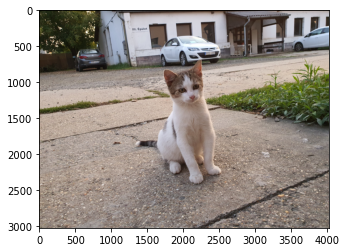

In [2]:
img_path = os.getenv("HOME")+"/aiffel/human_segmentation/images/cat_image.jpg"
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 세그멘테이션으로 사람 분리하기

#### 세그멘테이션(Segmentation)이란
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 **이미지 세그멘테이션(image segmentation)**이라고 한다.

**시맨틱 세그멘테이션(sementic segmentation)** 물리적 의미 단위로 인식하는 세그멘테이션 사람, 자동차, 비행기 등 물리적인 단위로 분류하는 방법

시멘틱세그멘테이션은 사람이라는 추상적인 정보를 이미지에서 추출해 내는 방법, 사람이 누구던지 같은 라벨로 표현하지만 **인스턴스 세그멘테이션(Instance segmentation)**은 사람 개개인별로 다른 라벨을 가지게 한다. 여러사람이 한 이미지에 등장할 때 객체를 분할해서 인식하는 것이 목표이다.





In [3]:
# # 저장할 파일 이름 지정
# model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
# model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# # pixellib 제공하는 모델 url
# model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# # 다운로드
# urllib.request.urlretrieve(model_url, model_file)

In [ ]:
# model = semantic_segmentation()
# model.load_pascalvoc_model(model_file)

In [5]:
model_path = os.getenv('HOME') + '/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
model = semantic_segmentation()
model.load_pascalvoc_model(model_path)

앞의 예제를 통해 모델을 다운로드 했기 때문에 경로에서 불러오는 코드로 변경

In [6]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

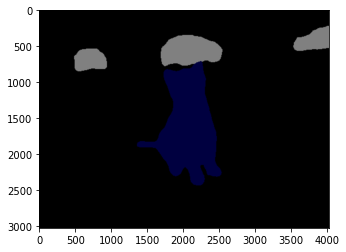

In [8]:
plt.imshow(output)
plt.show()

In [9]:
segvalues

{'class_ids': array([0, 7, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
car
cat


In [11]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype = int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind>>channel) & 1) << shift
    ind >>= 3
    
colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
colormap[8]

array([64,  0,  0])

앞의 사람과 달리 이번에 우리가 찾아야 할 것은 고양이 `cat`이다.   
위 `LABEL_NAMES`를 보면 8번 인덱스가 고양이임을 알 수 있다.

In [13]:
seg_color = (0, 0, 64)

항상 잊지 말아야 할것은 BGR순서 이므로 RGB로 바꿔서 작성해 준다.

(3024, 4032)


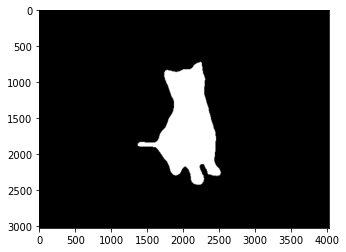

In [14]:
seg_map = np.all(output == seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

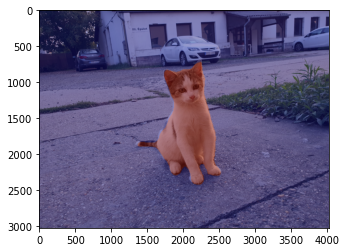

In [15]:
img_show = img_orig.copy()

# True, False 값을 각각 255, 0으로 바꿔줌
img_mask = seg_map.astype(np.uint8) * 255

# 255, 0을 적당한 색상으로 바꿔본다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 흐리게 만들기

`blur()`함수 사용

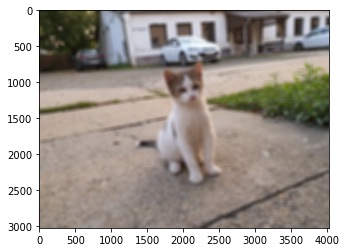

In [16]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (60,60))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

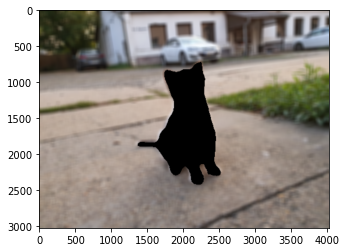

In [17]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경과 사람 합치기

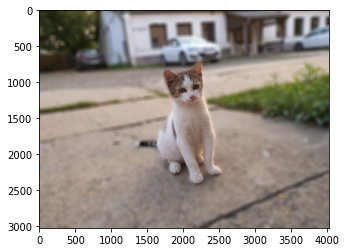

In [18]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 고양이 마무리

고양이 이미지도 무리 없이 잘 된 것을 볼 수 있다.   
딱히 어려움 없이 앞의 셀카와 같이 코드 몇 줄만 바꿔주면 된다.